<a href="https://colab.research.google.com/github/data-alch3m1st/PyTorch_tinkering/blob/main/skortch_comp_vision_FashionMNIST_v6_3_RandomSearchCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### PyTorch CNN with "Skorch" - an sklearn wrapper for PyTorch! ###

**Purpose**
Rather than building and testing multiple CNNs with the potential for dozens of hyper-param combos, using sklearn's grid search cross validation (or in this case, `RandomizedSearchCV`) to take a basket of hyperparams options, run a series of them (randomly) through a few epochs and going with the best performer in a full `PyTorch` native, functionized train/test/eval loop.

In [25]:
# !pip install skorch
# !pip install torchmetrics

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from skorch import NeuralNetClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix
    , accuracy_score, ConfusionMatrixDisplay
    )
from torchmetrics import Accuracy, ConfusionMatrix
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
from timeit import default_timer as timer
from tqdm import tqdm

warnings.filterwarnings("ignore")

In [6]:
# MacoOS device agnostic code:

if torch.cuda.is_available():
    device = "cuda" # Use NVIDIA GPU (if available)
elif torch.backends.mps.is_available():
    device = "mps" # Use Apple Silicon GPU (if available)
else:
    device = "cpu" # Default to CPU if no GPU is available

device

'cuda'

In [7]:
# Dataset Preparation

transform = transforms.Compose([
    transforms.ToTensor()
    , transforms.Normalize((0.5,), (0.5,))
])

# Load the FashionMNIST dataset
dataset = datasets.FashionMNIST(
    './data', train=True
    , download=True, transform=transform)

# Split into training and testing sets
X = dataset.data.float().unsqueeze(1)  # Convert to float and add channel dimension
y = dataset.targets

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2
    , random_state=27
    , stratify=y
)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 161kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.18MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 12.5MB/s]


(torch.Size([48000, 1, 28, 28]),
 torch.Size([48000]),
 torch.Size([12000, 1, 28, 28]),
 torch.Size([12000]))

In [8]:
# Wrap in DataLoader for batching

train_loader = DataLoader(
    list(zip(X_train, y_train))
    , batch_size=256
    , shuffle=True)

test_loader = DataLoader(
    list(zip(X_test, y_test))
    , batch_size=256
    , shuffle=False)

In [9]:
# Define the CNN Module

class SimpleCNN(nn.Module):
    def __init__(self, channels=32, dropout=0.0):
        super().__init__()
        self.conv1 = nn.Conv2d(1, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(channels, channels * 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear((channels * 2) * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(self.dropout(x)))
        return self.fc2(x)

In [10]:
# Wrap with Skorch NeuralNetClassifier
net = NeuralNetClassifier(
    module=SimpleCNN
    , criterion=nn.CrossEntropyLoss
    , max_epochs=5
    , lr=0.001
    , optimizer=torch.optim.Adam
    , batch_size=256
    , iterator_train__shuffle=True
    , device=device
)

# Fit the model
net.fit(X_train, y_train)

print("Train accuracy:", net.score(X_train, y_train))

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.6760       0.8738        0.3622  2.7773
      2        0.3315       0.8856        0.3260  1.3657
      3        0.2931       0.8927        0.3094  1.3697
      4        0.2603       0.8988        0.2889  1.3274
      5        0.2340       0.9031        0.2893  1.3317
Train accuracy: 0.92125


In [11]:
%%time

# RandomizedSearchCV for Hyperparameter Tuning
param_dist = {
    "module__channels": [32, 64]
    , "module__dropout": [0.0, 0.25, 0.5]
    , "lr": [1e-4, 3e-4, 1e-3]
    , "optimizer": [torch.optim.Adam]
    , "batch_size": [256]
}

rs = RandomizedSearchCV(
    estimator=net
    , param_distributions=param_dist
    , n_iter=10
    , cv=2
    , scoring="accuracy"
    , verbose=1
    , random_state=27
    , n_jobs=-1
)

rs.fit(X_train, y_train)

print("Best CV accuracy:", rs.best_score_)
print("Best params:", rs.best_params_)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.9102       0.8721        0.3538  2.1024
      2        0.3685       0.8948        0.2925  2.0879
      3        0.3250       0.8972        0.2875  2.1043
      4        0.2928       0.9006        0.2673  2.0929
      5        0.2741       0.9086        0.2574  2.5962
Best CV accuracy: 0.889625
Best params: {'optimizer': <class 'torch.optim.adam.Adam'>, 'module__dropout': 0.5, 'module__channels': 64, 'lr': 0.0003, 'batch_size': 256}
CPU times: user 12.8 s, sys: 4.48 s, total: 17.3 s
Wall time: 1min 49s


In [12]:
# Send results to a dataframe for clean review;

results = pd.DataFrame(rs.cv_results_)
results[[
    "mean_test_score"
    , "std_test_score"
    , "params"
]].sort_values("mean_test_score", ascending=False, inplace=True)

results.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_optimizer,param_module__dropout,param_module__channels,param_lr,param_batch_size,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,7.669859,0.088503,0.784436,0.005414,<class 'torch.optim.adam.Adam'>,0.25,32,0.0003,256,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",0.890917,0.882625,0.886771,0.004146,2
1,6.157737,0.046839,0.693632,0.039708,<class 'torch.optim.adam.Adam'>,0.50,32,0.0010,256,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",0.883833,0.876125,0.879979,0.003854,7
2,5.774103,0.148035,0.976736,0.201383,<class 'torch.optim.adam.Adam'>,0.00,32,0.0001,256,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",0.869083,0.873625,0.871354,0.002271,10


In [14]:
# Evaluate Performance with Best Model
# ---------------------------------------------------------
best_model = rs.best_estimator_
best_model

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=SimpleCNN(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fc1): Linear(in_features=6272, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=10, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  ),
)

In [15]:
y_pred = best_model.predict(X_test)

# Print metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = ConfusionMatrix(num_classes=10, task='multiclass')
cm_tensor = cm(torch.tensor(y_pred), y_test)

Accuracy: 0.8998333333333334
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.87      0.85      1200
           1       0.99      0.97      0.98      1200
           2       0.83      0.83      0.83      1200
           3       0.88      0.92      0.90      1200
           4       0.82      0.81      0.81      1200
           5       0.98      0.97      0.98      1200
           6       0.75      0.70      0.73      1200
           7       0.95      0.97      0.96      1200
           8       0.98      0.99      0.98      1200
           9       0.98      0.96      0.97      1200

    accuracy                           0.90     12000
   macro avg       0.90      0.90      0.90     12000
weighted avg       0.90      0.90      0.90     12000



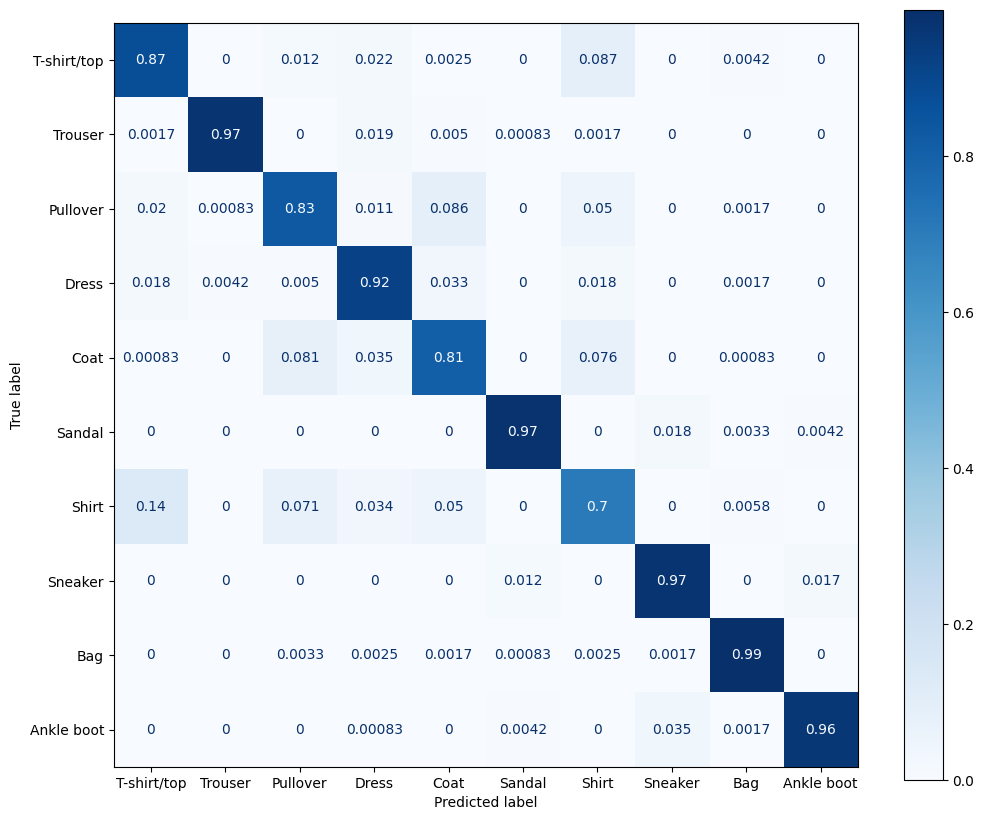

In [17]:
fig, ax = plt.subplots(figsize=(12, 10))

# # Plot confusion matrix
# disp = ConfusionMatrixDisplay.from_predictions(
#     y_test, y_pred
#     , display_labels=dataset.classes
#     , cmap='Blues'
#     , normalize='true', xticks_rotation=45
# )

disp.plot(ax=ax, cmap='Blues')
plt.show();

In [18]:
# Training/Test Loops (PyTorch Native)
def train_step(model, loader, loss_fn, optimizer, accuracy_fn, device):
    model.train()
    total_loss, total_acc = 0, 0
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += accuracy_fn(y_pred.argmax(dim=1), y).item()
    return total_loss / len(loader), total_acc / len(loader)


def test_step(model, loader, loss_fn, accuracy_fn, device):
    model.eval()
    total_loss, total_acc = 0, 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            total_loss += loss.item()
            total_acc += accuracy_fn(y_pred.argmax(dim=1), y).item()
    return total_loss / len(loader), total_acc / len(loader)

In [19]:
# Set the final model with the best params (including channels & dropout)

model = SimpleCNN(
    channels=rs.best_params_["module__channels"]
    , dropout=rs.best_params_["module__dropout"]
).to(device)

model

SimpleCNN(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=6272, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [20]:
%%time

# Train the Best Model

optimizer = rs.best_params_["optimizer"](model.parameters(), lr=rs.best_params_["lr"])
loss_fn = nn.CrossEntropyLoss()
accuracy_fn = Accuracy(task='multiclass', num_classes=10).to(device)

epochs = 20
for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(
        model, train_loader, loss_fn, optimizer, accuracy_fn, device)
    test_loss, test_acc = test_step(
        model, test_loader, loss_fn, accuracy_fn, device)
    print(
        f"Epoch {epoch+1}/{epochs} - "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f} - "
        f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}"
    )

  5%|▌         | 1/20 [00:02<00:50,  2.65s/it]

Epoch 1/20 - Train Loss: 1.0896, Train Acc: 0.78 - Test Loss: 0.3636, Test Acc: 0.87


 10%|█         | 2/20 [00:05<00:47,  2.62s/it]

Epoch 2/20 - Train Loss: 0.3579, Train Acc: 0.87 - Test Loss: 0.3185, Test Acc: 0.88


 15%|█▌        | 3/20 [00:07<00:43,  2.58s/it]

Epoch 3/20 - Train Loss: 0.3162, Train Acc: 0.88 - Test Loss: 0.2909, Test Acc: 0.89


 20%|██        | 4/20 [00:10<00:40,  2.54s/it]

Epoch 4/20 - Train Loss: 0.2904, Train Acc: 0.89 - Test Loss: 0.2696, Test Acc: 0.90


 25%|██▌       | 5/20 [00:12<00:37,  2.49s/it]

Epoch 5/20 - Train Loss: 0.2683, Train Acc: 0.90 - Test Loss: 0.2801, Test Acc: 0.90


 30%|███       | 6/20 [00:15<00:34,  2.45s/it]

Epoch 6/20 - Train Loss: 0.2533, Train Acc: 0.90 - Test Loss: 0.2715, Test Acc: 0.90


 35%|███▌      | 7/20 [00:17<00:31,  2.42s/it]

Epoch 7/20 - Train Loss: 0.2366, Train Acc: 0.91 - Test Loss: 0.2516, Test Acc: 0.91


 40%|████      | 8/20 [00:19<00:28,  2.41s/it]

Epoch 8/20 - Train Loss: 0.2256, Train Acc: 0.91 - Test Loss: 0.2564, Test Acc: 0.91


 45%|████▌     | 9/20 [00:22<00:26,  2.43s/it]

Epoch 9/20 - Train Loss: 0.2156, Train Acc: 0.92 - Test Loss: 0.2433, Test Acc: 0.91


 50%|█████     | 10/20 [00:24<00:24,  2.43s/it]

Epoch 10/20 - Train Loss: 0.2031, Train Acc: 0.92 - Test Loss: 0.2432, Test Acc: 0.91


 55%|█████▌    | 11/20 [00:27<00:21,  2.41s/it]

Epoch 11/20 - Train Loss: 0.1978, Train Acc: 0.93 - Test Loss: 0.2455, Test Acc: 0.91


 60%|██████    | 12/20 [00:29<00:19,  2.40s/it]

Epoch 12/20 - Train Loss: 0.1887, Train Acc: 0.93 - Test Loss: 0.2423, Test Acc: 0.91


 65%|██████▌   | 13/20 [00:31<00:16,  2.39s/it]

Epoch 13/20 - Train Loss: 0.1793, Train Acc: 0.93 - Test Loss: 0.2308, Test Acc: 0.92


 70%|███████   | 14/20 [00:34<00:14,  2.42s/it]

Epoch 14/20 - Train Loss: 0.1765, Train Acc: 0.93 - Test Loss: 0.2439, Test Acc: 0.92


 75%|███████▌  | 15/20 [00:36<00:12,  2.42s/it]

Epoch 15/20 - Train Loss: 0.1667, Train Acc: 0.94 - Test Loss: 0.2319, Test Acc: 0.92


 80%|████████  | 16/20 [00:39<00:09,  2.41s/it]

Epoch 16/20 - Train Loss: 0.1642, Train Acc: 0.94 - Test Loss: 0.2367, Test Acc: 0.92


 85%|████████▌ | 17/20 [00:41<00:07,  2.41s/it]

Epoch 17/20 - Train Loss: 0.1522, Train Acc: 0.94 - Test Loss: 0.2348, Test Acc: 0.92


 90%|█████████ | 18/20 [00:43<00:04,  2.40s/it]

Epoch 18/20 - Train Loss: 0.1515, Train Acc: 0.94 - Test Loss: 0.2433, Test Acc: 0.92


 95%|█████████▌| 19/20 [00:46<00:02,  2.42s/it]

Epoch 19/20 - Train Loss: 0.1448, Train Acc: 0.94 - Test Loss: 0.2401, Test Acc: 0.92


100%|██████████| 20/20 [00:48<00:00,  2.44s/it]

Epoch 20/20 - Train Loss: 0.1392, Train Acc: 0.95 - Test Loss: 0.2358, Test Acc: 0.92
CPU times: user 47.6 s, sys: 194 ms, total: 47.8 s
Wall time: 48.8 s


In [21]:
# Ensure the model is in evaluation mode
model.eval()

# Collect all predictions and true labels
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

# Concatenate all predictions and labels into single tensors
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

In [22]:
print(confusion_matrix(all_labels, all_preds))
print('\n=================================================================\n')
print(classification_report(all_labels, all_preds))

[[1071    1   15   19    1    0   87    0    6    0]
 [   1 1181    0   13    3    0    2    0    0    0]
 [  28    2 1006   12   78    0   73    0    1    0]
 [  17    5    3 1138   16    0   18    0    3    0]
 [   2    2   57   61 1010    0   67    0    1    0]
 [   0    0    0    0    0 1176    0   15    1    8]
 [ 136    0   42   33   44    1  940    0    4    0]
 [   0    0    0    0    0   11    0 1170    0   19]
 [   3    0    1    3    4    1    3    2 1183    0]
 [   0    0    0    0    0    1    0   39    1 1159]]


              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1200
           1       0.99      0.98      0.99      1200
           2       0.90      0.84      0.87      1200
           3       0.89      0.95      0.92      1200
           4       0.87      0.84      0.86      1200
           5       0.99      0.98      0.98      1200
           6       0.79      0.78      0.79      1200
           7       0.95      0.97 

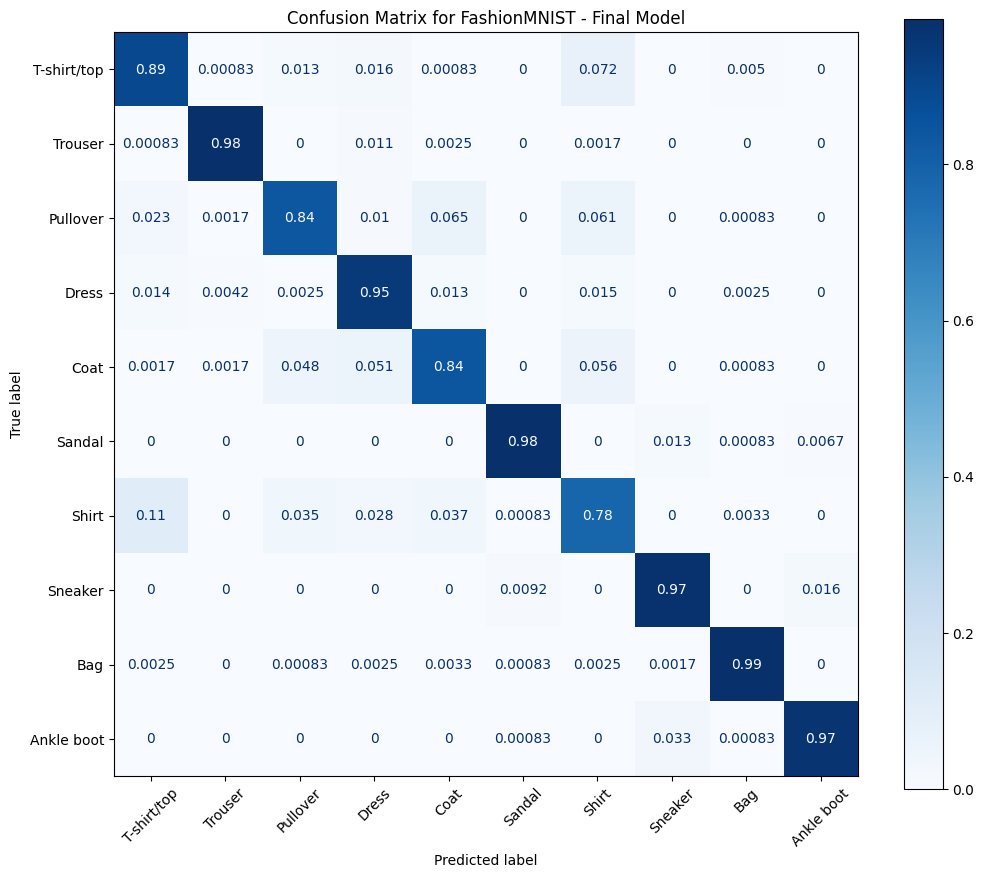

In [24]:
# Compute the confusion matrix

# Compute the confusion matrix
fig, ax = plt.subplots(figsize=(12, 10))

# # Display the normalized confusion matrix
# disp = ConfusionMatrixDisplay.from_predictions(
#     all_labels, all_preds
#     , display_labels=dataset.classes
#     , normalize='true'
# )
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix for FashionMNIST - Final Model")
plt.show();